In [1]:
# imports
from jpeg import *
from huffman import *
import cv2
import matplotlib.pyplot as plt

# Video Coding

## Motion Estimation - Motion Compensation

In this section we define two critical functions for video encoding/decoding

- motion_estimation: a function that etimates the motion from one frame to the other by finding the best match of each block in the current frame in the reference frame based on optical flow to minimize the difference between consecutive frames

- motion_compensation: a function that predicts the next frame based on the reference frame and the motion vectors that is returned from running the motion estimation on the current frame

In [2]:
def motion_estimation(refrence_frame, current_frame, macroblock_size = (16,16)):
    '''
    A function for motion estimation that takes in the reference frame, 
    current frame and macroblock size and returns an array of motion vectors,
    one for each macroblock in the reference frame
    '''
    # padding the frames to be divisble by the macroblock_size
    ref_frame,_,_ = pad_img_blocks(refrence_frame, macroblock_size[0])
    curr_frame,_,_ = pad_img_blocks(current_frame, macroblock_size[0])

    # create array for stroing motion vectors
    motion_vectors = np.zeros((int(ref_frame.shape[0]/macroblock_size[0]),int(ref_frame.shape[1]/macroblock_size[1]),2), dtype = int)

    #iterate over the current frame
    for y in range(0, curr_frame.shape[0], macroblock_size[0]):
        for x in range(0, curr_frame.shape[1], macroblock_size[1]):
            # slice the current macroblock for the current frame
            curr_mb = curr_frame[y:y+macroblock_size[0], x:x+macroblock_size[1]]
            #we will use SAD(sum of absolute difference to choose our best match)
            sad_min = float('inf')
            best_mv = (0,0)

            # iterate over the refernce frame with 1 pixel accuracy to find best match for current macroblock
            for i in  [-1, 0, 1]: # the sliding window can either go up or down or may not move
                if (y + i) < 0 or (y+ macroblock_size[0] +i) > curr_frame.shape[0]:  #if block at the horizontal edge of the frame
                    continue 
                for j in [-1, 0, 1]: # the sliding window can either go left or right or may not move
                    if (x + j) < 0 or (x+ macroblock_size[1] + j) > curr_frame.shape[1]: #if block at the vertical edge of the frame
                        continue 
                    # extract the current macroblock for the refernce frame
                    y_ = y + i #macroblock shifted coordinates
                    x_ = x + j
                    ref_mb = ref_frame[y_:y_+macroblock_size[0], x_:x_+macroblock_size[1]]

                    # calculate SAD between refernce and current frames
                    sad = np.sum(np.abs(ref_mb.astype(int) - curr_mb.astype(int)))
                    #check if new best match
                    if sad < sad_min or (i == 0 and j == 0 and sad == sad_min):
                        sad_min = sad
                        best_mv = (int(i), int(j))
            
            motion_vectors[y//macroblock_size[0], x//macroblock_size[1]] = best_mv
    return motion_vectors 

def motion_compensation(refernce_frame, motion_vectors, macroblock_size= (16,16)):
    '''A function that takes the refrence frame and the motion vectors of its macroblocks and
       returns a predicted frame based on the optical flow of the macroblocks estimated from the motion vectors
    '''

    #create an array to store the predicted frame
    predicted_frame = np.zeros_like(refernce_frame, dtype = np.uint8)

    # iterate over the reference frame in macroblock-sized increments
    for y in range(0, refernce_frame.shape[0], macroblock_size[0]):
        for x in range(0, refernce_frame.shape[1], macroblock_size[1]):
            # get the current motion vector
            mv = motion_vectors[y//macroblock_size[0], x//macroblock_size[1]]

            # get the corresponding macroblocks from the reference frame and place it in the predicted frame
            y_ = y + mv[0] # macroblock shifted coordinates
            x_ = x + mv[1]
            y_shift = macroblock_size[0]
            x_shift = macroblock_size[1]
            if y + macroblock_size[0] > refernce_frame.shape[0]:
                y_shift = refernce_frame.shape[0] - y
            if x + macroblock_size[1] > refernce_frame.shape[1]:
                x_shift = refernce_frame.shape[1] - x
            predicted_frame[y:y+y_shift, x:x+x_shift] =\
                refernce_frame [y_: y_+y_shift, x_:x_+x_shift]

    return predicted_frame

## Video Encoding

In [3]:
# video encoder
'''
Specifications of the encoder/decoder:
    specifying the quantization matrix:
    there are three quantization matrices that we can use that are illustrated in the quant_mat.py script:
        high_comp : quantization table with high compression performance (large coeffiecients)
        low_comp  : quantization table with low compression performance (small coefficients)
        ijg       : standard quantization table for the idependent jpeg group
    to choose the quantization table we specify the quantization mode(str) to the jpeg encoder and decode functions

    specifying the i_frame_rate:
    this is the rate by which we send a complete (I) frame to the decoder without predictive coding.
    increasing this rate would increase the overall compression but would affect the quality of the decoded video
    decreasing this rate would result in better quality but would cost less compression so it's a trade off
    we chose it to be 30 as we are processing 30fps videos and we wouldn't expect a huge change in the video frames within more than 1 sec
'''
quant_mode_def = 'high_comp'
i_frame_rate_def = 30

def video_encode(filename, q_m = quant_mode_def, i_rate = i_frame_rate_def):
    '''
    Parameters:
    -   filename: string of the file name of the video
    -   q_m: string that defines the quantization table
    -   i_rate: I frame rate
    This is the main video encoder function and it encodes the video according to the following steps:
    - it reads the video file and extracts its infromation (frame shape, etc)
    - it defines a vector stream and appends header information
    - it loops over all the video frames and encodes each frame with two possibilities:
        >> if it's an I frame it encodes(jpeg) the frame completely and appends its encoded vector to the vector stream
           then it decodes the encoded frame to be the newly reconstructed frame 
        >> if it's a P frame it performs motion estimation and motion compensation to get the prediction of the current frame and its motion vector,
           using this prediction it computes the difference between the predicted frame and the latest reconstructed frame and it encodes (jpeg)
           the frame difference and appends it to the vector stream along with its motion vector. It then decodes the difference back to add it to the predicted 
           frame to get the newly reconstructed frame
    - After encoding all the frames, the output vector stream is entropy encoded (huffman) to get the encoded bitstream and the huffman tree (code book)
    The function returns:
    -   huffman encoded bitstream of the entire video
    -   huffman tree 
    -   bitstream_length
    '''

    # reading the video file
    source = cv2.VideoCapture(filename)
    stream = [] # output stream
    c = 0 # frame count

    # extract frame shape
    h, w = int(source.get(cv2.CAP_PROP_FRAME_WIDTH)), int(source.get(cv2.CAP_PROP_FRAME_HEIGHT)) 

    # calculate the shape of the motion vector
    macroblock_size = 16
    mv_y, mv_x = np.int32(ceil(np.float32(h)/macroblock_size)), np.int32(ceil(np.float32(w)/macroblock_size))

    # creating stop word to mark end of frame 
    # this number will not appear in the output stream except at the end of each frame or frame diff
    stop = -69420 
    #adding header information to the vector stream
    stream.extend([i_rate, stop, mv_y, mv_x])


    # running the loop
    while True:
        # extracting the frames
        ret, frame = source.read()
        if not(ret): break # if no frames left
        # converting to gray-scale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if c % i_rate == 0:
            # if i_frame, send completely without predective coding
            encoded_frame = encode_jpeg(gray, quant_mode=q_m)
            # add encoded frame to  output stream
            stream.extend(encoded_frame) 
            # adding stop word
            stream.append(stop) 
            # reconstruct the frame by jpeg decoding
            reconst_ref_frame = decode_jpeg(encoded_frame,quant_mode=q_m )
        else:
            curr_frame = gray
            # performing motion estimation and motion compensation to get prediction for the current frame
            mv = motion_estimation(reconst_ref_frame, curr_frame)
            pred_frame = motion_compensation(reconst_ref_frame, mv)
            # finding the frame difference between current frame and predicted frame
            frame_diff = (curr_frame.astype(int) - pred_frame.astype(int))
            # encoding the frame difference
            encoded_diff = encode_jpeg(frame_diff, quant_mode=q_m)
            # add the encoded vector of the frame difference to the output stream
            stream.extend(encoded_diff)
            # adding the motion vector after reshaping to 1D to the output stream
            stream.extend(mv.reshape((1,-1)).tolist()[0])  
            # adding stop word
            stream.append(stop)    
            # reconstructing the current frame to be the new refrence frame
            decoded_diff = decode_jpeg(encoded_diff, quant_mode=q_m)
            reconst_ref_frame = (decoded_diff + pred_frame)

        c+=1
    
    source.release()
    print('Finished encoding. Number of frames =  ', c)

    # converting output vector stream to a space sperated string to perform huffman entropy encoding
    stream_str = ' '.join(map(str, stream))

    # huffman encoding
    hu = HuffCode(data = stream_str)
    stream_encoded, hufftree = hu.compress()

    print('Bitsream length = ', len(stream_encoded),' bits')

    return stream_encoded, hufftree, len(stream_encoded)

## Video Decoding

In [4]:
# video decoder
def video_decode (stream_encoded, hufftree, q_m = quant_mode_def):
    '''
    Parameter:
    -   stream_encoded: huffman encoded bitstream 
    -   hufftree: huffman tree of the encoded bitstream (code book)
    This is the main video decoder function and it decodes the video based on the following steps:
    - it decodes(huffman) the encoded bitstream of the video to get its vector (run-length-encoded) stream (array of integers)
    - it extracts the header information from the vector stream 
    - it loops over the vector stream until and its empty and performs decoding in one of two possibilites:
        >> if the recieved encoded frame is an I frame it decodes(jpeg) the frame and appends it to the list of frames
           and it becomes the new reconstructed frame
        >> if the recieved encoded frame is a P frame (frame difference and motion vector), it decodes(jpeg) the frame difference,
           and performs motion compensation using the last reconstructed frame and extracted motion vector to get the predicted frame
           which is then added to the decoded frame difference to get the new reconstructed frame which is also appended to the list of frames
    - it exports the frames into a video file that is named according to the used quantization table
    It returns a list of video frames and number of frames
    '''
    # huffman decoding of the incoming bit stream
    hu_dec = HuffCode()
    stream_decoded = hu_dec.decompress(hufftree, data_compressed = stream_encoded)

    # convert the decoded stream to an array of integers
    stream_array = list(map(int, stream_decoded.split()))

    # extract header information (I frame rate, stop word, motion vector shape)
    i_frame_rate, stop, mv_y, mv_x = stream_array[0:4]
    enc_stream = stream_array[4:]

    # calculate motion vector flat length
    mv_len =  mv_y* mv_x * 2
    # motion vector length in the vector stream
    # frame count
    c = 0
    # frames list
    frames = []


    while len(enc_stream) > 0:
        # calculating frame length by searching for the stop word
        k, i = None, 0
        while k != stop:
            k = enc_stream[i]
            i+=1
        # slicing the frame from the encoded vector stream
        frame = enc_stream[:i-1]
        enc_stream = enc_stream[i:]

        # if i_frame don't extract motion vector as it is sent completely
        if c % i_frame_rate == 0:
            # decode the I frame 
            reconst_ref_frame_r = decode_jpeg(frame,  quant_mode=q_m)
        else:
            # the frame in this case consists of the encoded diff frame and motion vector(constant size)
            # the motion vector is at the end of the sliced frame
            encoded_diff_r = frame[:-mv_len]
            mv_r = frame[-mv_len:]
            # perform jpeg decoding on the encoded frame diff
            decoded_diff_r = decode_jpeg(encoded_diff_r, quant_mode=q_m)
            # reshaping the motion vector
            mv_reshaped = np.reshape(mv_r, (mv_x,mv_y,2))  # SEND IN HEADER
            # get the predicted frame
            pred_frame_r = motion_compensation(reconst_ref_frame_r, mv_reshaped)
            # add predicted frame to the reconstructed difference to get current reconstructed frame
            reconst_ref_frame_r = pred_frame_r + decoded_diff_r
        
        frames.append(reconst_ref_frame_r)
        c+=1
    print('Finished decoding. Number of frames =  ', c)

    # exporting the decoded video
    # extracting frame shape
    (h,w) = frames[0].shape
    output_vid = q_m + '_' + 'outputvideo.mp4'
    writer = cv2.VideoWriter(output_vid, cv2.VideoWriter_fourcc(*"MP4V"),30, (w,h), isColor = False)
    for frame in frames:
        writer.write(frame.astype(np.uint8))
    writer.release()

    return (frames, c)
    

# Results

## High Compression 

In [5]:
# video file name
video_file = 'video_lotr.mp4'
# compression specifications
quant_mode = 'high_comp'
i_rate = 10
# encoding
huff_bitsream_high, huff_tree_high, bitsream_length_high = video_encode(video_file, quant_mode, i_rate)
# decoding
frames_high, fpv_high = video_decode (huff_bitsream_high, huff_tree_high, quant_mode)

Finished encoding. Number of frames =   199
Compressed
Bitsream length =  93590096  bits
Decompressed
Finished decoding. Number of frames =   199


**Viewing sample frames from the decoded video** 

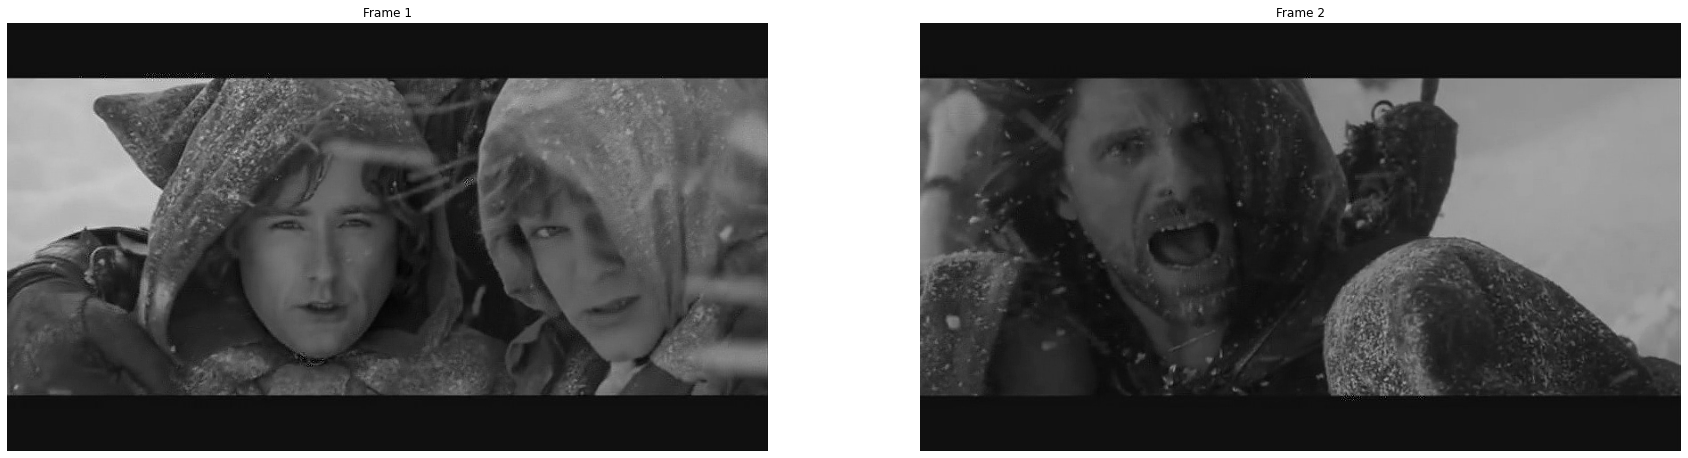

In [7]:
## viewing sample frames from the decoded video
f, axarr = plt.subplots(1,2, figsize=(30, 30))
f1, f2 = np.random.randint(fpv_high, size=2)
axarr[0].imshow(frames_high[f1], cmap='gray', vmin=0, vmax=255);
axarr[0].set_title("Frame 1")
axarr[0].axis('off');
axarr[1].imshow(frames_high[f2], cmap='gray', vmin=0, vmax=255);
axarr[1].set_title("Frame 2")
axarr[1].axis('off');

**compression ratio**

To calculate the compression ratio, we first calculate the uncompressed video size using the following formula:
uncompressed size = number of frames * frame_height * frame_width * 8 bits 

The compressed video size is the size of the bitstream returned from the huffman entropy encoder

In [8]:
# uncompressed video size
uncomp_size = fpv_high * frames_high[0].shape[0]* frames_high[0].shape[1] * 8 

# compressed video size 
comp_size  = bitsream_length_high

# compression ratio
comp_ratio = uncomp_size/comp_size

print ('Uncompressed video size = ', uncomp_size, ' bits')
print ('Compressed video size = ', comp_size, ' bits')
print ('Compression Ratio = ', comp_ratio)

Uncompressed video size =  652592640  bits
Compressed video size =  93590096  bits
Compression Ratio =  6.972881404032324


## Low Compression 

In [9]:
# video file name
video_file = 'video_lotr.mp4'
# compression specifications
quant_mode = 'low_comp'
i_rate = 10
# encoding
huff_bitsream_low, huff_tree_low, bitsream_length_low = video_encode(video_file, quant_mode, i_rate)
# decoding
frames_low, fpv_low = video_decode(huff_bitsream_low, huff_tree_low, quant_mode)

Finished encoding. Number of frames =   199
Compressed
Bitsream length =  249576480  bits
Decompressed
Finished decoding. Number of frames =   199


**Viewing sample frames from the decoded video** 

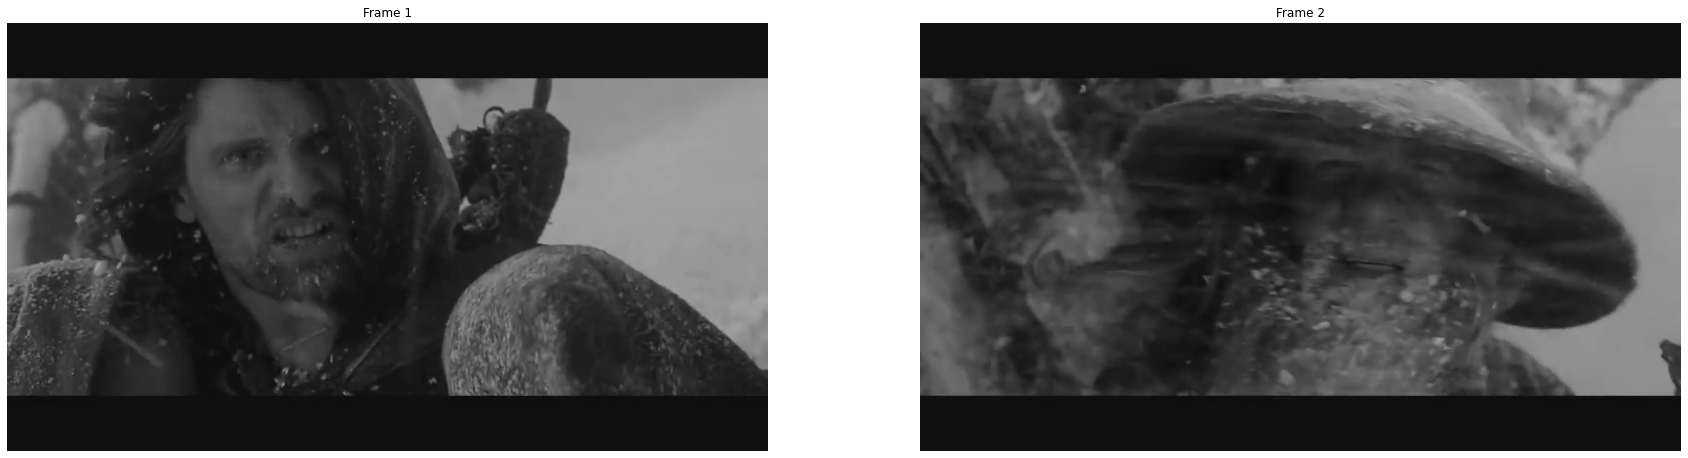

In [10]:
## viewing sample frames from the decoded video
f, axarr = plt.subplots(1,2, figsize=(30, 30))
f1, f2 = np.random.randint(fpv_low, size=2)
axarr[0].imshow(frames_low[f1], cmap='gray', vmin=0, vmax=255);
axarr[0].set_title("Frame 1")
axarr[0].axis('off');
axarr[1].imshow(frames_low[f2], cmap='gray', vmin=0, vmax=255);
axarr[1].set_title("Frame 2")
axarr[1].axis('off');

**compression ratio**

To calculate the compression ratio, we first calculate the uncompressed video size using the following formula:
uncompressed size = number of frames * frame_height * frame_width * 8 bits 

The compressed video size is the size of the bitstream returned from the huffman entropy encoder

In [11]:
# uncompressed video size
uncomp_size = fpv_low * frames_low[0].shape[0]* frames_low[0].shape[1] * 8 

# compressed video size 
comp_size  = bitsream_length_low

# compression ratio
comp_ratio = uncomp_size/comp_size

print ('Uncompressed video size = ', uncomp_size, ' bits')
print ('Compressed video size = ', comp_size, ' bits')
print ('Compression Ratio = ', comp_ratio)

Uncompressed video size =  652592640  bits
Compressed video size =  249576480  bits
Compression Ratio =  2.614800240791921


## Standard Compression 

In [26]:
# video file name
video_file = 'video_lotr.mp4'
# compression specifications
quant_mode = 'ijg'
i_rate = 10
# encoding
huff_bitsream, huff_tree, bitsream_length = video_encode(video_file, quant_mode, i_rate)
# decoding
frames, fpv = video_decode (huff_bitsream, huff_tree, quant_mode)

Finished encoding. Number of frames =   199
Compressed
Bitsream length =  51769857  bits
Decompressed
Finished decoding. Number of frames =   199


**Viewing sample frames from the decoded video** 

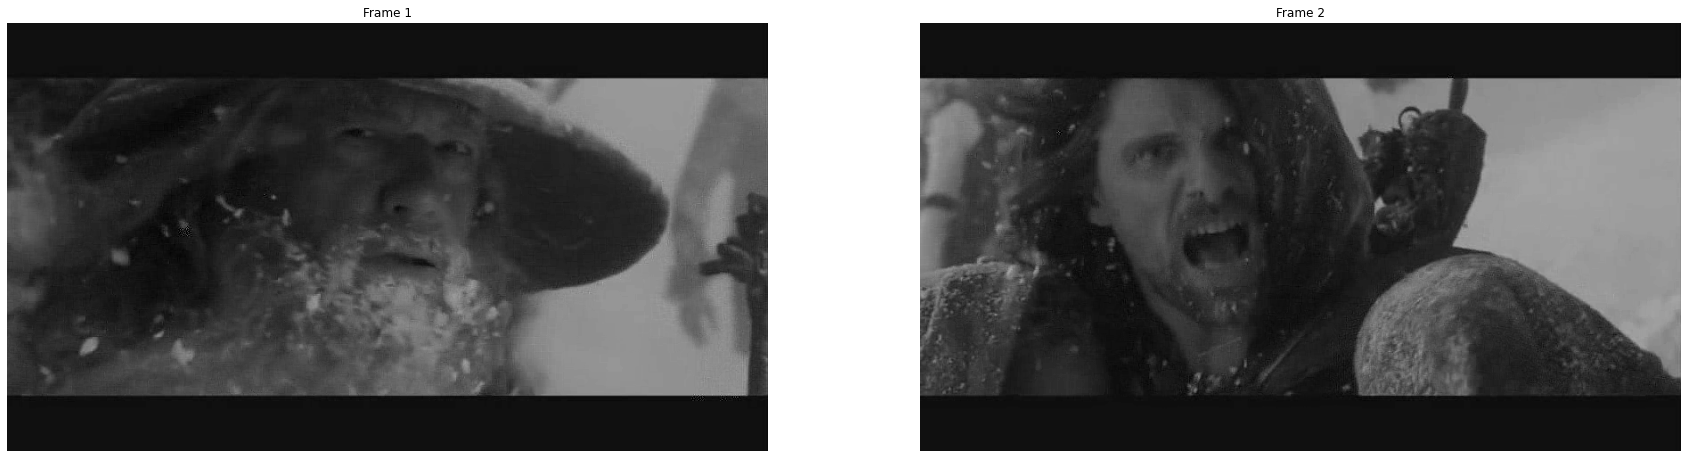

In [27]:
## viewing sample frames from the decoded video
f, axarr = plt.subplots(1,2, figsize=(30, 30))
f1, f2 = np.random.randint(fpv, size=2)
axarr[0].imshow(frames[f1], cmap='gray', vmin=0, vmax=255);
axarr[0].set_title("Frame 1")
axarr[0].axis('off');
axarr[1].imshow(frames[f2], cmap='gray', vmin=0, vmax=255);
axarr[1].set_title("Frame 2")
axarr[1].axis('off');

**compression ratio**

To calculate the compression ratio, we first calculate the uncompressed video size using the following formula:
uncompressed size = number of frames * frame_height * frame_width * 8 bits 

The compressed video size is the size of the bitstream returned from the huffman entropy encoder

In [28]:
# uncompressed video size
uncomp_size = fpv * frames[0].shape[0]* frames[0].shape[1] * 8 

# compressed video size 
comp_size  = bitsream_length

# compression ratio
comp_ratio = uncomp_size/comp_size

print ('Uncompressed video size = ', uncomp_size, ' bits')
print ('Compressed video size = ', comp_size, ' bits')
print ('Compression Ratio = ', comp_ratio)

Uncompressed video size =  652592640  bits
Compressed video size =  51769857  bits
Compression Ratio =  12.60564888174213


# Discussion:


Based on the compression ratio and the quality of the decoded videos, we have observed the following:

- The standard quantization table achieved the best compression ratio, followed by the high compression table, and finally the low compression table which had the worst performance.

- The standard table performed better than the high compression table because it still had larger coefficients in the upper left half of the matrix, where the most common frequencies occur. This allows the standard table to provide more compression by dividing the values in the upper left half of the DCT block by larger coefficients.

- While this likely means that the standard table reduces the quality more than the high compression table, the difference in image quality is minimal relative to the difference in compression performance.

- It's also worth noting that the coefficients of the standard table are based on human sensitivity to pixel values. This means that the standard table throws away information that minimizes image quality, but is barely noticeable by the human eye. This is why it can achieve high compression with good quality.